## Lab 4 - P and PI Control

Use high, low, and * values in feedback control.

Here is the table of gains to use:

|Trial|Kp|Ki|
|---:|---:|---:|
|1|1.0|0.0|
|2|1000.0|0.0|
|* 3|||



> \* [Kevin Starr, Control Tuning, Chapter 5, min:sec = 20:43](https://youtu.be/m_LhFFfuKfo?list=PLOgEb39vsYlsZGdZV-aYeaH4gxYVXxsuw&t=1243)





Number of oscillations = 1.       Final error = -0.000000000 degrees C.


'end of simulation'

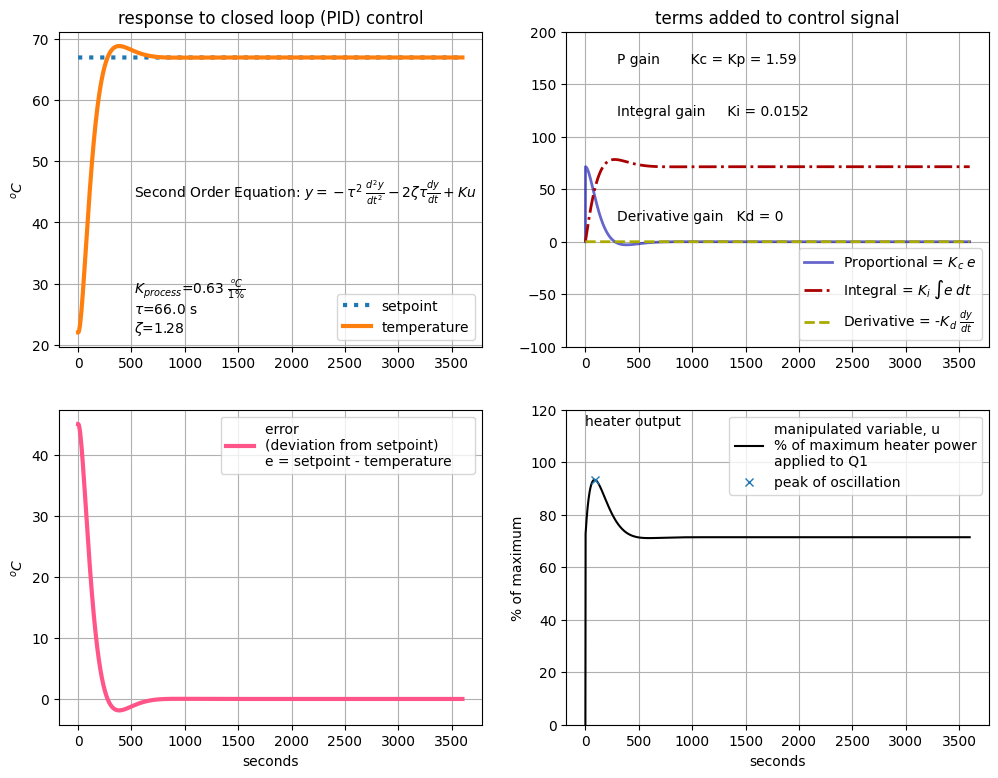

In [89]:
"""
Tune a P, PI, and PID controller.
The system to be controlled is a Temperature Control Lab.
Consider upcoming notes for the mathematical values of
a Second Order Fit to TCLab.
"""

import numpy as np
from matplotlib.pyplot import *
import scipy.integrate as sci
from scipy.signal import find_peaks

# TC Lab
# these parameters were experimentally derived from prior lab work
k= 0.63       # process gain, in 63 degC per 100 percent power
              # units = degC per 1% power
tau=66.0   # time constant in seconds
zeta=1.28  # no units, damping cooefficient (under, critical, over damped)

n=3600 # number of seconds for this simulation
t=np.linspace(0,n,n+1)
# reserve a place to store results
r=np.zeros(n+1)
y=np.zeros(n+1)
dydt=np.zeros(n+1)
e=np.zeros(n+1)
prop=np.zeros(n+1)
inte=np.zeros(n+1)
deri=np.zeros(n+1)
feed=np.zeros(n+1)
u=np.zeros(n+1)

T0=22       # ambient initial room temperature
target=67   # <--- set the desired temperature here

# setpoint values for each point in time
sp=target*np.ones_like(t)

# second order model
# split into two first order ODEs
def tcl(x,t,u):
    y      = x[0]-T0  # diff from quiescient pt
    dydt   = x[1]
    d2ydt2 = (-2*zeta*tau*dydt - y + k*u)/tau**2
    return [dydt,d2ydt2]

def plot_results():
    # prepare to plot
    figure(figsize=(12,9),dpi=100)

    subplot(2,2,1)
    plot(t,sp,':',label='setpoint',lw=3)
    plot(t,y, '-',label='temperature',lw=3)
    legend()
    grid()
    ylabel(r'$^oC$')
    text(520,44,r'Second Order Equation: ' \
     +r'$y=-\tau^2\;\frac{d^2y}{dt^2}-2\zeta\tau\frac{dy}{dt}+K u$')

    s2 = r'$K_{process}$' + f'={k:.2f} ' + r'$\frac{^oC}{1\%}$' + f'\n' \
       + r'$\tau$'  + f'={tau:.1f} s\n' \
       + r'$\zeta$' + f'={zeta:.2f}'
    text(520,22,s2)
    title('response to closed loop (PID) control')

    subplot(2,2,2)
    plot(t,Kp*prop,'-' ,color='#00a',lw=2,label=r'Proportional = $K_c\; e$',alpha=0.6)
    plot(t,Ki*inte,'-.',color='#a00',lw=2,label=r'Integral = $K_i\; \int e\; dt$')
    plot(t,Kd*deri,'--',color='#aa0',lw=2,label=r'Derivative = -$K_d\; \frac{dy}{dt} $')
    string=f'P gain       Kc = Kp = {Kp:0.3g}'; text(300,170,string)
    string=f'Integral gain     Ki = {Ki:0.3g}'; text(300,120,string)
    string=f'Derivative gain   Kd = {Kd:0.3g}'; text(300, 20,string)
    #string=f'Feedforward gain  Kf = {Kf:0.3g}'; text(300,-40,string)
    legend(loc=4)
    grid()
    ylim([-100,200])
    title('terms added to control signal')

    subplot(2,2,3)
    plot(t,e, \
      '#ff5588', \
      lw=3, \
      label=f'error \
      \n(deviation from setpoint) \
      \ne = setpoint - temperature')
    grid()
    legend()
    ylabel(r'$^oC$')
    xlabel('seconds')

    subplot(2,2,4)
    plot(t,u,'#000')
    grid()
    ylabel('% of maximum')
    xlabel('seconds')
    text(0,114,'heater output')
    ylim([0,120])

    (peaks,_)=find_peaks(u,prominence=(1,))
    print(f"Number of oscillations = {len(peaks)}. \
      Final error = {e[-1]: 12.9f} degrees C.")
    plot(peaks,u[peaks],'x')
    legend(['manipulated variable, u' \
        + '\n% of maximum heater power' \
        + '\napplied to Q1','peak of oscillation'])

def run_controller(Kp,Ki,Kd,Kf):
    dt=t[1]-t[0] # time diff between steps
    x0 = [T0,0]  # initial temperature and initial slope dT/dt

    # initial values on the step 0
    r[0]=sp[0]
    y[0]=T0;y[1]=y[0]
    e[0]=r[0]-y[0]

    # do the loop for each time step
    for i in range(1,n):

        r[i]=sp[i]
        e[i]=r[i]-y[i]

        prop[i]=e[i]

        inte[i]=inte[i-1] + e[i]*dt
        # limit the windup
        if(Ki*inte[i]>100 and Ki!=0.0):
            inte[i]=100/Ki
        if(Ki*inte[i]<0):
            inte[i]=0

        # dydt[i]=(y[i]-y[i-1])/dt # allow dydt to be calculated by odeint below
        # not here for best accuracy
        deri[i]=-dydt[i]

        # feedforward (optional)
        feed[i]=r[i]-y[0]

        # here is the PID.FF control signal calculation
        u[i] = Kp*e[i] + Ki*inte[i] + Kd*deri[i] + Kf*1/k*feed[i]

        # bind power to stay inside real limits
        if(u[i]>100):
            u[i]=100
        if(u[i]<0):
            u[i]=0

        #u[i]=100

        # initial values:  T, slope of T
        x0=[y[i],dydt[i]]
        # start and end time for this step of simulation
        tv=[t[i-1],t[i]]

        # simulate the results for this step
        ans=sci.odeint(tcl,x0,tv,args=(u[i],))

        # store results for each time step
        y[i+1]=ans[-1,0]     # returns T in column 0, dT/dt in column 1
        dydt[i+1]=ans[-1,1]  # first row is initial condition
                             # last row (last=-1) gives results of this step

    # truncate the ending of the run
    u[n]=u[n-1]
    e[n]=e[n-1]=e[n-2]
    inte[n]=inte[n-1]
    return(y,u,e)

# starr gains, fast response
Kp=1/k    # proportional gain
Ki=1/tau  # integral gain
Kd=0.0    # derivative gain
Kf=0.0    # feedforward gain

run_controller(Kp,Ki,Kd,Kf)
plot_results()
'end of simulation'